Just like in MFA there is of-course uncertainty in the Input Output (IO) data [1,2,3]. However, because of the shear size of the (Environmentally Extended) IO data bases such as EXIOBASE, this is also very often ignored. However, it is failry straight forward to capture at leats some of this uncertainty using an asbolute local/global sensitivity analysis just as we did with the Matrace model last week.\

In this tutorial, you will work with an aggregated version of EXIOBASE 3.4 (*year 2011*) (the aggregation was done to decrease computation time for this turotial, but methods can generally be applied to the full size IO table (if you computers memory and speed are suffiecient, if not you will need to look for alternative approaches. )
The aggregated version has 6 Regions and 11 product/industry sectors. All different Final Demand has been aggregated.

The goal of today is to have performed a local sensitivity analysis on the Final demand vector for a region of your choice. Next have a look at how the uncertainty in the sectoral numbers in the stressor matrix (for CO2) for CH/RoW impact the EU28 carbon footprint. 

For this tutorial you will use/adapt code from this week and last Friday (uncertainty in MFA) and will mostly do everything yourself. 

[1] Rodrigues et al 2018: http://pubs.acs.org/doi/10.1021/acs.est.8b00632 \
[2] Wieland et al. 2018: http://dx.doi.org/10.1080/09535314.2017.1350831 \
[3] Lenzen et al 2010: http://www.tandfonline.com/doi/abs/10.1080/09535311003661226


# 1. Step: Import of required libraries

In this step all the libraries needed within the script are imported

In [5]:
import sys
import xlrd, xlsxwriter
import numpy as np
import pandas as pd
import time
import datetime
import scipy.io
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 2. Step: Locating the Database Address

The database address is defined in this step.

In [2]:
ProjectSpecs_Path_Main     = 'C:/Users/ghardadi/Documents/'
ProjectSpecs_Name_ConFile  = 'MRIO_Config.xlsx'
ProjectSpecs_DataPath1     = 'C:/Users/ghardadi/EXIOBASE_2/'
ProjectSpecs_PackagePath1  = 'C:/Users/ghardadi/'

sys.path.append(ProjectSpecs_PackagePath1)

# 3. Step: Extracting the Information from Config File

In this step we collect the information from config file and start the simulation.

In [3]:
# Load project-specific config file
Project_Configfile  = xlrd.open_workbook(ProjectSpecs_Path_Main + 'Calculation/' + ProjectSpecs_Name_ConFile)
Project_Configsheet = Project_Configfile.sheet_by_name('Config')

# Naming script and defining of name specifications (e.g. date when the script was used)
Name_Script        = Project_Configsheet.cell_value(6,3)
Name_Scenario      = Project_Configsheet.cell_value(5,3)
StartTime          = datetime.datetime.now()
TimeString         = str(StartTime.year) + '_' + str(StartTime.month) + '_' + str(StartTime.day) + '__' + str(StartTime.hour) + '_' + str(StartTime.minute) + '_' + str(StartTime.second)
DateString         = str(StartTime.year) + '_' + str(StartTime.month) + '_' + str(StartTime.day)
Path_Result        = ProjectSpecs_Path_Main + 'Results/'

# Importing information about Exiobase 2.2 from excel file
EB3_NoofCountries  = int(Project_Configsheet.cell_value(4,8))
EB3_NoofProducts   = int(Project_Configsheet.cell_value(5,8))
EB3_NoofIndustries = int(Project_Configsheet.cell_value(6,8))
EB3_NoofIOSectors  = int(Project_Configsheet.cell_value(7,8))
EB3_NoofFDCategories = int(Project_Configsheet.cell_value(8,8))

# Start the timer
Time_Start = time.time()
print('Start of simulation: ' + time.asctime() + '.')

Start of simulation: Thu Feb  6 09:08:19 2020.


# 4. Step: Import Exiobase 3.6

Now, Exiobase 3.6 will be imported. This includes the following:

L-Matrix containing the Leontief-Inverse

S-Matrix containing the emissions

Y-Matrix containing the final demands

FDE-Matrix containing the direct emissions caused by the final demands

In [4]:
print('Loading Exiobase 3.6 data.')

MRIO_Name = 'EXIOBASE3_13_Mon_49R_2018_06_01_ITCpxp.mat'

Filestring_Matlab_in = ProjectSpecs_DataPath1 + MRIO_Name

print('Import L-Matrix (Leontief-Inverse)')
MRIO_L = scipy.io.loadmat(Filestring_Matlab_in)['EB3_L_ITC']

print('Import S-Matrix (Emissions).')
MRIO_S = scipy.io.loadmat(Filestring_Matlab_in)['EB3_S_ITC']

print('Import Y-Matrix (Final Demands)')
MRIO_Y = scipy.io.loadmat(Filestring_Matlab_in)['EB3_Y']

print('Import FDE-Matrix (Direct Emissions from Final Demand).')
MRIO_FDE = scipy.io.loadmat(Filestring_Matlab_in)['EB3_FinalDemand_Emissions']

print('Import the Names of Industry Sectors.')
MRIO_Prod = scipy.io.loadmat(Filestring_Matlab_in)['EB3_ProductNames200']

print('Import the Names of Extension Codes.')
MRIO_Ext = scipy.io.loadmat(Filestring_Matlab_in)['EB3_Extensions']

print('Import the Names of Regions.')
MRIO_Reg = scipy.io.loadmat(Filestring_Matlab_in)['EB3_RegionList']

Loading Exiobase 3.6 data.
Import L-Matrix (Leontief-Inverse)
Import S-Matrix (Emissions).
Import Y-Matrix (Final Demands)
Import FDE-Matrix (Direct Emissions from Final Demand).
Import the Names of Industry Sectors.
Import the Names of Extension Codes.
Import the Names of Regions.


# 5. Step: Import characterisation factors

In order to calculate the environmental footprints, characterisation factors are needed
to convert the emissions received by S. L. Y to midpoint indicators

In [6]:
print('Import characterisation factors to calculate midpoint indicators.')

ImpactFile  = xlrd.open_workbook(ProjectSpecs_DataPath1 + 'Characterization_EB36.xlsx')
ImpactSheet = ImpactFile.sheet_by_name('Emissions')
ImpactCategory_Names = []
for m in range(0,36):
    ImpactCategory_Names.append(ImpactSheet.cell_value(0,m+1))
    
MRIO_Char = np.zeros((36,1707))
for m in range(0,36):
    for n in range(0,1707):
        MRIO_Char[m,n] = ImpactSheet.cell_value(n+1,m+1)

Import characterisation factors to calculate midpoint indicators.


# 6. Step: Selecting the final demand vectors

The Y vector is selected based on the environmental footprints that is going to be assessed. The demand emissions are also added in the footprint calculation. The environmental footprint assessed in this study is Carbon Footprint of German households.

In [7]:
print('Import characterisation factors to calculate midpoint indicators.')

FD_DE_HH = MRIO_Y[:,EB3_NoofFDCategories*5]
DE_DE_HH = MRIO_FDE[:,EB3_NoofFDCategories*5]

Import characterisation factors to calculate midpoint indicators.


# 7. Step: Simulating the Final Demand composition for Germany

Now that we can calculate the GWP footprint for a final demand vector, it is time to do a sensitivity analysis. 

* 1: Now given that we are quite sure about the total final demand of German Households, but not so sure on what products the money is spend, define a normalised final demand vector for German (or another country of your choice) by dividing the HH final demand by the total HH final demand. 
* 2: parameterize the your normalised FD vector with appropriate probability distributions. See tutorial from last Friday if you don't remember how to do this. Assign appropriate widths to the distributions, you can try different values later. 
* 3: Draw samples for each paramter in the FD vector (remember that this is again a normalised vector so you will need to scale the samples such that they add up to 1), and check that the samples are a reasonable representation for the original distributions. 
* 4: Check the time it would take calculate footprints for all your samples. And adjust sample size if necesarry. 
* 5: Run an MC on the absolute sensitivity if the GWP to the HH consumption split and plot the resulting distribution. (give your plot labels and a title) And calculate the median, mean, + and - ~1 and ~2 sigma errors.

In [42]:
FDshare_DE_HH = FD_DE_HH.reshape(49,200)

FDshare_DE_HH = np.nan_to_num(FDshare_DE_HH / FDshare_DE_HH.sum(axis=0))

FDshare_DE_HH = FDshare_DE_HH.reshape(9800,)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
#We will assume an uncertainty of 20%

FDshare_sigma_DE_HH = np.zeros(FDshare_DE_HH.shape)
for i in range(0,9800):
    FDshare_sigma_DE_HH[i] = FDshare_DE_HH[i] * 0.2
    if FDshare_sigma_DE_HH[i] < 1e-7:
        FDshare_sigma_DE_HH[i] = 1e-7

#Now here we calculate the a and b paramters for the truncated normal distribution
A = np.divide((- FDshare_sigma_DE_HH),FDshare_sigma_DE_HH, where=FDshare_sigma_DE_HH!=0)
B = np.divide((+ FDshare_sigma_DE_HH),FDshare_sigma_DE_HH, where=FDshare_sigma_DE_HH!=0)

#Now use list comprehension to build a list of truncnorm distributions for the different parameters. 
FDshare_DE_HH_Uncertain = [scipy.stats.truncnorm(a=a,b=b,loc=mu,scale=sigma) for a,b,mu,sigma in zip(A,B,FDshare_DE_HH, FDshare_sigma_DE_HH)]


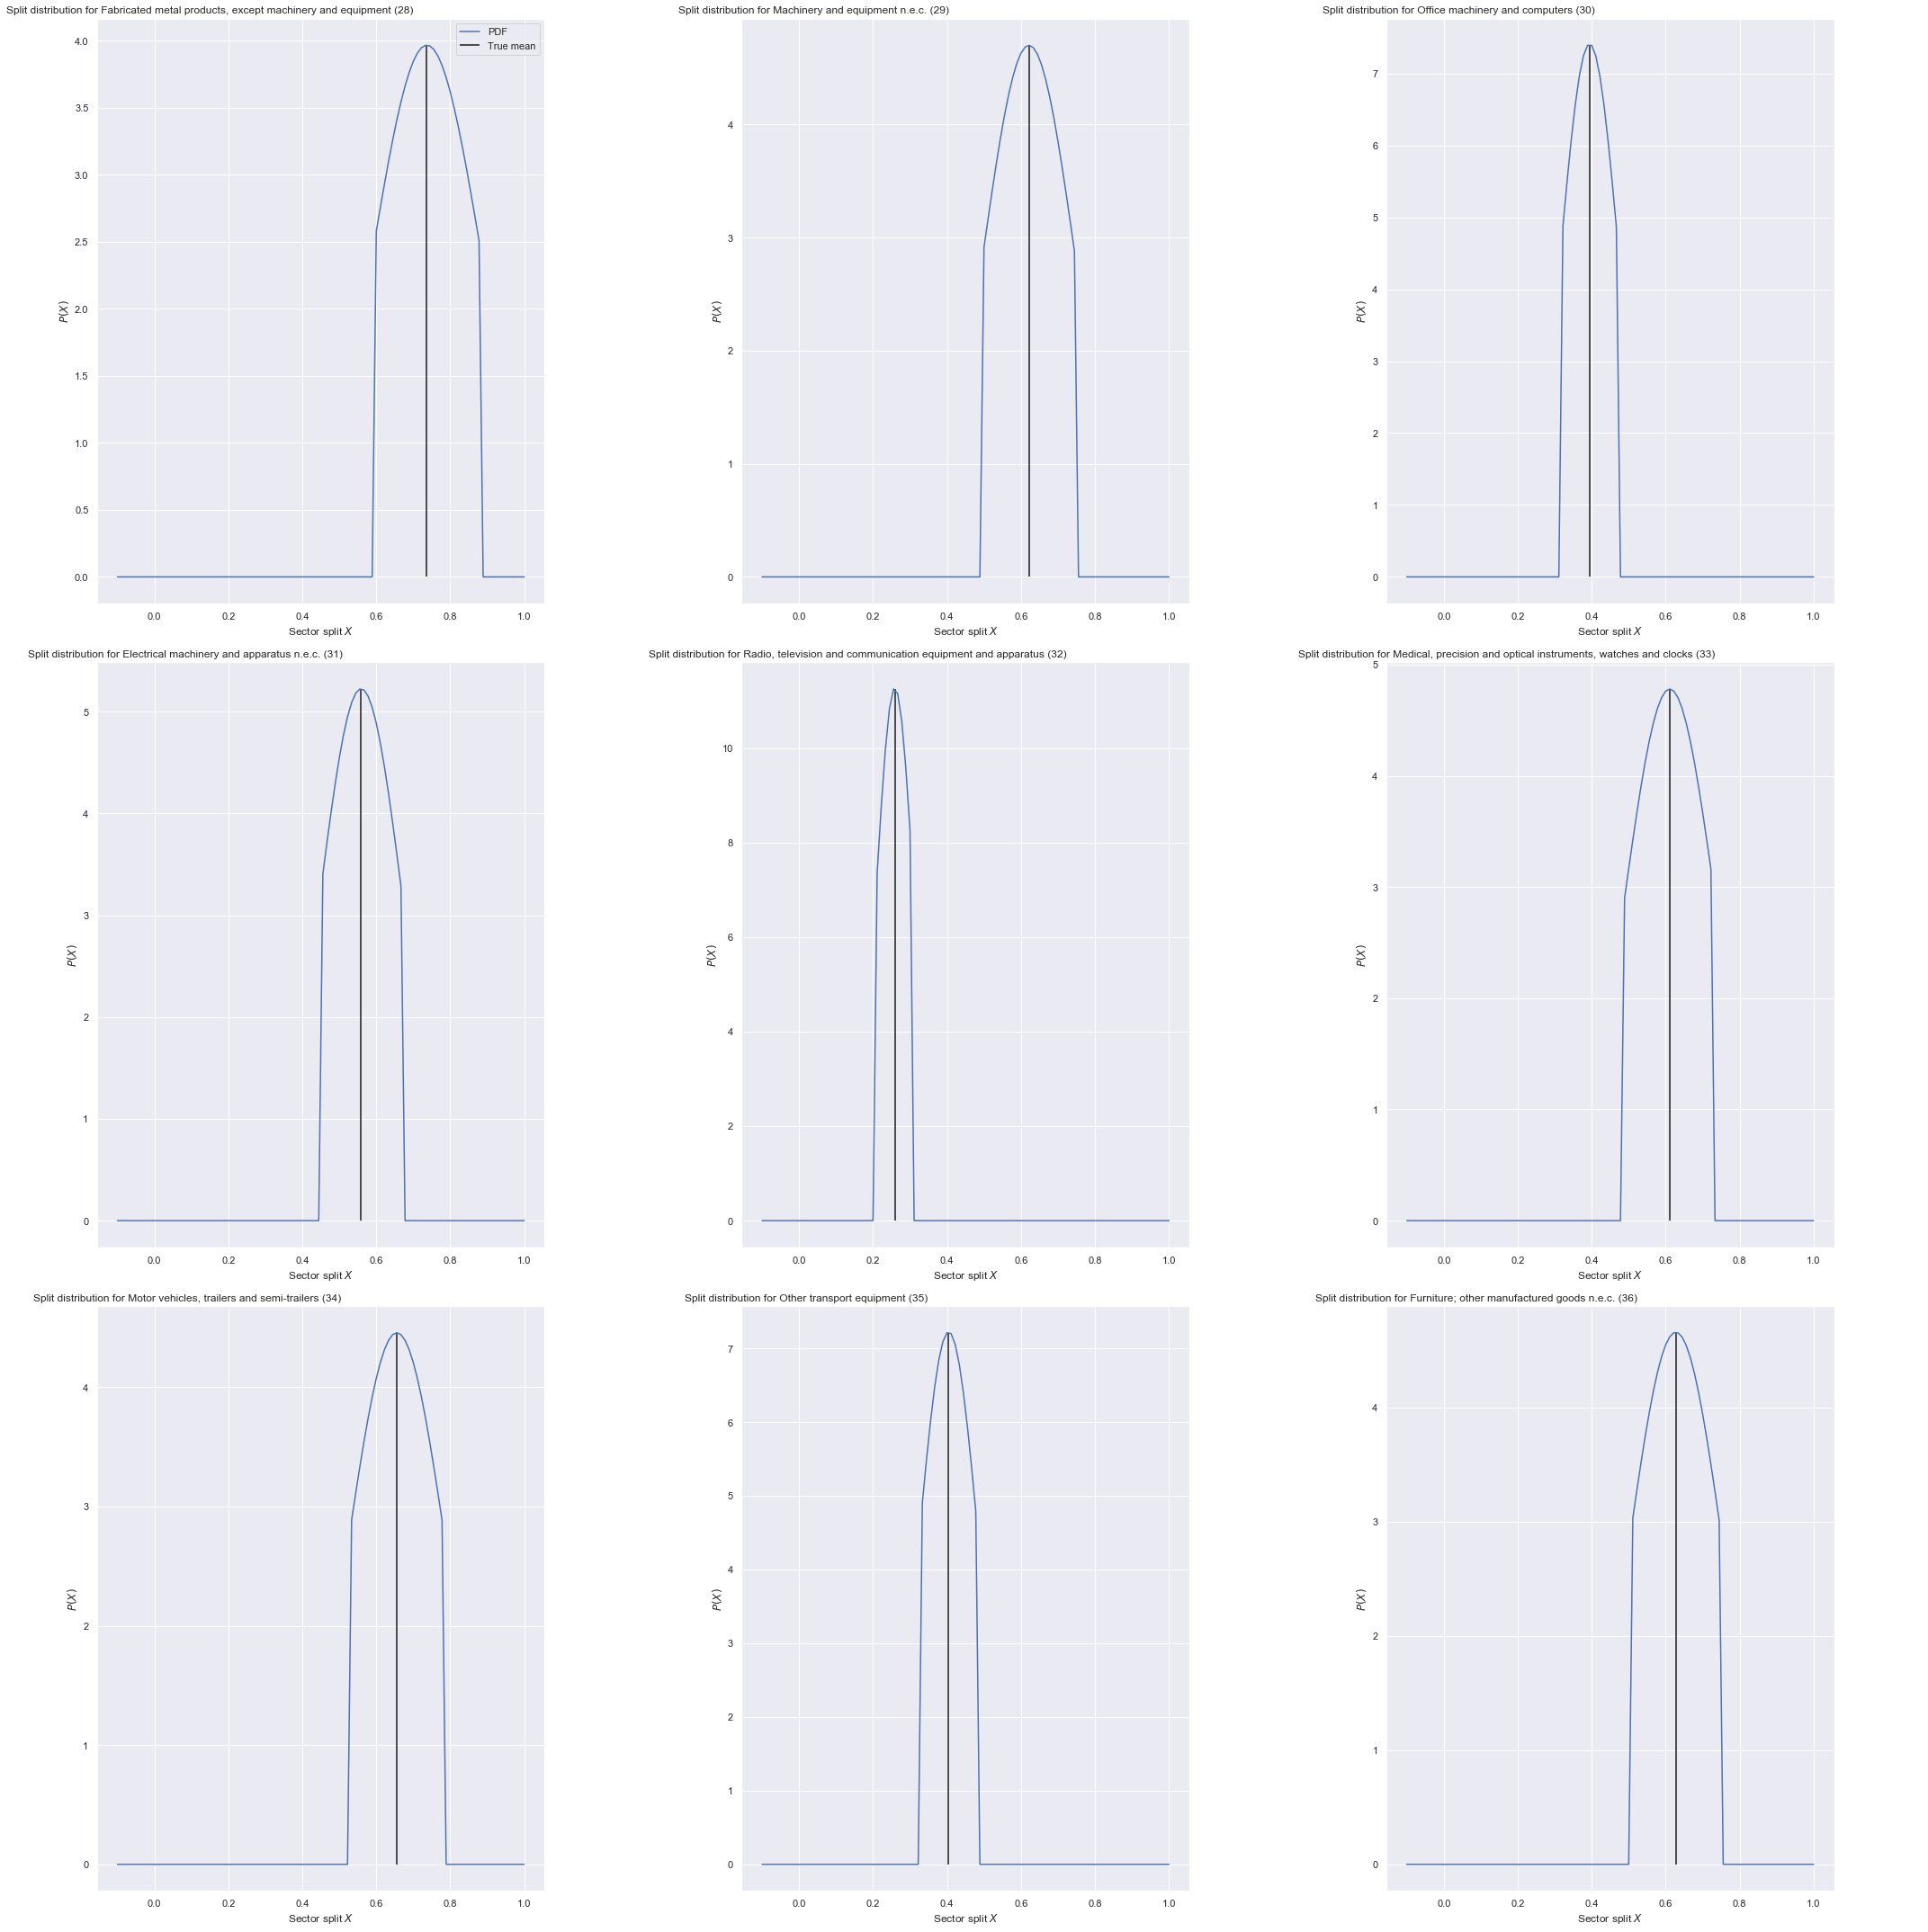

In [50]:
#Let's check if our probability distributions have worked by plotting them
x = np.linspace(-.1,1,100) #set the range
fig = plt.figure(figsize=(30,30))#make a figure
axes = fig.subplots(3,3)
for i,(par,ax,mean) in enumerate(zip(FDshare_DE_HH_Uncertain[1116:1125],axes.flatten(),FDshare_DE_HH[1116:1125])):
    ax.plot(x,par.pdf(x),label='PDF')
    ax.vlines(mean,ymin=0,ymax=par.pdf(x).max(),label='True mean')
    ax.set_xlabel('Sector split $X$')
    ax.set_ylabel('$P(X)$')
    ax.set_title('Split distribution for {}'.format(MRIO_Prod[i+116]))
    if i==0:
        ax.legend(loc=1)

fig.tight_layout()

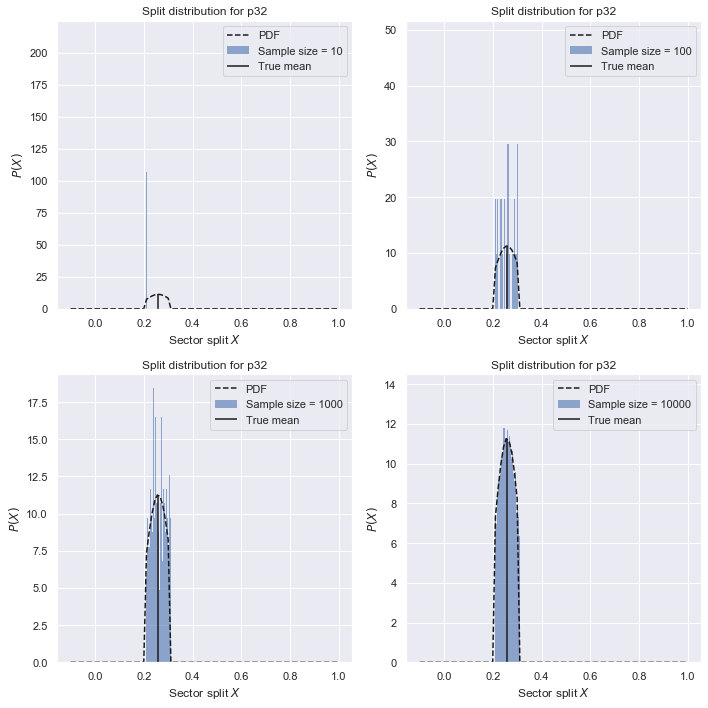

In [65]:
# hint1: check the help function of the distribution to see how to use the rvs function to draw samples.plt.hit?
p = 1120
par = FDshare_DE_HH_Uncertain[p]
sample_size= [10,100,1000,10000]
fig = plt.figure(figsize=(10,10))
axes = fig.subplots(2,2)
for i,ax in enumerate(axes.flatten()):
    ss = sample_size[i]
    ax.hist(par.rvs(size=ss),bins=100, density=True, alpha=0.6, edgecolor='none',label='Sample size = {}'.format(ss))
    ax.plot(x,par.pdf(x),'k--', label='PDF')#next(linecycler), label=Def_ProductNames[i]
    ax.vlines(FDshare_DE_HH[p],ymin=0,ymax=par.pdf(x).max(), label='True mean')
    ax.set_xlabel('Sector split $X$')
    ax.set_ylabel('$P(X)$')
    ax.set_title('Split distribution for {}'.format("p32"))
    ax.legend(loc=1)
fig.tight_layout()

# 8. Step: Estimating The Required Time for Calculating Footprint

We will estimate the required time needed for calculating German household Carbon Footprint per looping.

In [55]:
%%timeit
EmbEm_DE_HH = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(FD_DE_HH)/1e9

#Total National Indirect Embodied Emissions

102 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
#so running 10000 loops should take about
print('{} seconds or {} minutes'.format(round(10000*0.102, 0), round(10000*0.102/60, 2)))
#plus some overhead!

1020.0 seconds or 17.0 minutes


# 9. Step: Calculating the emissions inventory and footprint

The inventories enlist the emissions embodied in the household consumption for each emissions type.
The footprint will show the total GHG emissions, measured in CO<sub>2</sub> equivalent.

In [86]:
N_samples = 5000 #Choose your sample size
FD_DE_HH_samples = np.zeros((N_samples, len(FDshare_DE_HH))) #first define an 'empty' array for our results
for i,par in enumerate(FDshare_DE_HH_Uncertain): #remember the last one was 0
    FD_DE_HH_samples[:,i] = par.rvs(size=N_samples)

In [87]:
#calculate the sum of the parameter for each sample to check that they indeed do not all add up to 1
FD_DE_HH_sum = FD_DE_HH_samples.reshape(5000,49,200).sum(axis=1)

print(FD_DE_HH_sum) #print to check
print(FD_DE_HH_sum.shape)

[[ 1.03695118e+00  1.02533766e+00  9.52176175e-01 ...  8.77333535e-01
   9.86553616e-01 -2.04122661e-07]
 [ 1.13120146e+00  9.67102418e-01  9.44917515e-01 ...  9.31522329e-01
   9.00342152e-01 -9.17679290e-08]
 [ 9.08392234e-01  9.81499914e-01  8.97317654e-01 ...  9.70007216e-01
   8.21880521e-01 -2.53404864e-07]
 ...
 [ 9.60257460e-01  8.54944796e-01  9.55254371e-01 ...  1.02443715e+00
   8.99007975e-01  5.38456848e-07]
 [ 8.62999838e-01  9.96143776e-01  1.02621381e+00 ...  1.01833630e+00
   8.37659978e-01  2.34694505e-07]
 [ 1.00808180e+00  8.45512979e-01  1.04612833e+00 ...  9.06956877e-01
   9.72232712e-01 -3.06232931e-08]]
(5000, 200)


In [88]:
#Now rescale 
FD_DE_HH_samples_scaled = np.einsum('ijk,ik->ijk',FD_DE_HH_samples.reshape(5000,49,200),1/FD_DE_HH_sum)
print(FD_DE_HH_samples_scaled.sum(axis=1))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [92]:
FD_DE_HH_MC = np.zeros((N_samples,49,200))
FD_DE_HH_pp = FD_DE_HH.reshape(49,200).sum(axis=0)

for i in range(N_samples):
    for j in range(0,200):
        FD_DE_HH_MC[i,:,j] = FD_DE_HH_samples_scaled[i,:,j] * FD_DE_HH_pp[j]

In [93]:
FD_DE_HH_MC = FD_DE_HH_MC.reshape(5000,9800)
FD_DE_HH_MC

array([[-2.24209953e-07,  5.61579005e+00,  4.09670056e+00, ...,
         1.15535190e+01,  4.60132235e-05, -0.00000000e+00],
       [ 1.57676850e-07,  6.40733025e+00,  3.79411246e+00, ...,
         1.25225209e+01,  1.09830723e-04, -0.00000000e+00],
       [ 3.16141620e-07,  6.21848395e+00,  4.91903808e+00, ...,
         1.20839991e+01, -8.30924959e-05,  0.00000000e+00],
       ...,
       [-2.88813695e-07,  5.25737920e+00,  4.24864822e+00, ...,
         1.16275777e+01, -2.40754808e-04,  0.00000000e+00],
       [ 1.39429542e-07,  5.79021885e+00,  3.88800530e+00, ...,
         9.47198415e+00,  3.46232185e-04,  0.00000000e+00],
       [-1.80413818e-07,  6.10470243e+00,  3.16737215e+00, ...,
         1.22133488e+01, -8.27196785e-06,  0.00000000e+00]])

In [94]:
Footprint_samples = np.zeros((N_samples))

for i in range(N_samples):
    Footprint_samples[i] = MRIO_Char[4,:].dot(MRIO_S).dot(MRIO_L).dot(FD_DE_HH_MC[i,:])

In [100]:
FPpc_025, FPpc_16, FPpc_median, FPpc_84, FPpc_975 = np.percentile(Footprint_samples,[2.5,16,50,84,97.5])/80645605

In [128]:
print(FPpc_975)
print(FPpc_median)

6923.207057462247
6889.179403662154


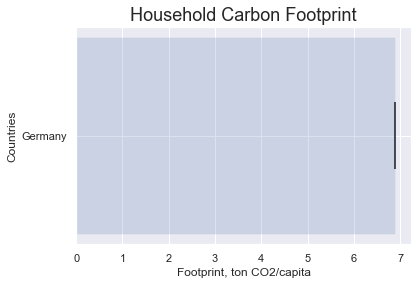

In [126]:
plt.barh('Germany', FPpc_median/1e3, height=0.2, yerr=(FPpc_975-FPpc_median)/1e3, alpha=0.2, align='center')
plt.xticks()

plt.ylabel('Countries')
plt.xlabel('Footprint, ton CO2/capita')
plt.title('Household Carbon Footprint', size=18)

plt.show()

### Saving the Monte Carlo Results

In [131]:
writer = pd.ExcelWriter(Path_Result + 'MC_Carbon Footprint.xlsx', engine='xlsxwriter')

FP = pd.DataFrame(Footprint_samples, columns = ['MC Household Footprint'])

FP.to_excel(writer, sheet_name='MC1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

## Uncertainty in Footprints due to environmental extensions. 

Another common source of uncertainty in IO is the matrix of environmental extensions [1]. Due to globally intertwined supply chains, high uncertainty on the impacts in one country country can lead to high uncertainty on the footprint of other countries. Here we will investigate how uncertainty on the carbon intensity of Industries in China can have an impact on the total footprint of EU28 countries (incl Germany). 

* 1: Identify the row and columns in the extensions matrix representing the CO2 combustion numbers for the Chinese industry sectors. 
* 2: Sum them up to get the total emissions in China
* 3: Now create a normalised vector for these emissions and define probability distributions for each. 
* 4: Sample from these normalised emissions and rescale to 1
* 5: Calculate the stressor vector for all samples by dividing by the total Chinese production x_CN (Note that this is a subset of the vector x above).
* Run an MC with your samples (you can either create samples of for the entire S matrix (using the real S matrix and your stressor subvectors for CH) or adjust/define the/a function to just substitute the values for CH in the S matrix). Plot the distribution of the total GWP 100 footprint for the EU28 countries (incl Germany) and calculate the median, mean, + and - ~1 and ~2 sigma errors. Note that you will have to aggregate the final demand categories (all 4) and regions (EU28 w/o DE and DE).


In [16]:
print('Script is finished. Terminating logging process and closing all log files.')
Time_End = time.time()
Time_Duration = Time_End - Time_Start

print('End of simulation: ' + time.asctime() + '.')
print('Duration of simulation: %.1f seconds.' % Time_Duration)

Script is finished. Terminating logging process and closing all log files.
End of simulation: Wed Jan 29 11:54:24 2020.
Duration of simulation: 417.6 seconds.
